#### Feature Engineering and Encoding

In [1]:
import pandas as pd


In [2]:
df=pd.read_csv('../data/processed/credit_data_cleaned.csv')
df.head()

,clientid,income,age,loan,default,loan_log
0,1,66155.92510,59,8106.532131,0,9.000549
1,2,34415.15397,48,6564.745018,0,8.789621
2,3,57317.17006,63,8020.953296,0,8.989937
3,4,42709.53420,46,6103.642260,0,8.716805
4,5,66952.68885,19,8770.099235,1,9.079217


In [5]:
# step 4.1: seperate features and target
X = df.drop(columns=['default'])
y= df['default']

# We separate features and target to prevent data leakage.
# The model should learn patterns only from input variables and not have access to the target during training.
# This also ensures a clean and reliable modeling pipeline.

In [ ]:
# Step 4.2: Numerical Feature Engineering
# Step 4.2.1: Log transaformation
# we already have transformed loan using log transformation in previous step.
# log transformation reduces the effect of the extreme values
# drop original column
df.drop(columns=['loan'], inplace=True)


KeyError: "['loan'] not found in axis"

In [ ]:
# Ratio features
df['loan_to_income']=df['loan_log']/df['income']
df.head()

# Higher loan relative to income → higher default risk

,clientid,income,age,default,loan_log,loan_to_income
0,1,66155.92510,59,0,9.000549,0.000136
1,2,34415.15397,48,0,8.789621,0.000255
2,3,57317.17006,63,0,8.989937,0.000157
3,4,42709.53420,46,0,8.716805,0.000204
4,5,66952.68885,19,1,9.079217,0.000136


In [22]:
df.head()

,income,age,default,loan_log,loan_to_income
0,66155.92510,59,0,9.000549,0.000136
1,34415.15397,48,0,8.789621,0.000255
2,57317.17006,63,0,8.989937,0.000157
3,42709.53420,46,0,8.716805,0.000204
4,66952.68885,19,1,9.079217,0.000136


In [19]:
# dropping client_id as it is just an identifier
df.drop(columns=['clientid'], inplace=True)

In [20]:
df.head()

,income,age,default,loan_log,loan_to_income
0,66155.92510,59,0,9.000549,0.000136
1,34415.15397,48,0,8.789621,0.000255
2,57317.17006,63,0,8.989937,0.000157
3,42709.53420,46,0,8.716805,0.000204
4,66952.68885,19,1,9.079217,0.000136


In [24]:
# dropping income due to high multicollinearity and less statistical significance
df.drop(columns=['income'], inplace=True)

“Although income is intuitively important, statistical testing showed weak direct association with default, and it introduced multicollinearity. Since its information was better captured through the loan-to-income ratio, I removed the raw income feature to improve model stability.

In [25]:
df.head()

,age,default,loan_log,loan_to_income
0,59,0,9.000549,0.000136
1,48,0,8.789621,0.000255
2,63,0,8.989937,0.000157
3,46,0,8.716805,0.000204
4,19,1,9.079217,0.000136


In [ ]:
# Step 4.3: Feature Scaling
from sklearn.preprocessing import StandardScaler

num_cols=['age','loan_log','loan_to_income'] #features to scale




“Scaling is part of feature engineering conceptually, but I apply it only after train-test split by fitting the scaler on training data to avoid data leakage.”

In [28]:
# final feature check
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             2000 non-null   int64  
 1   default         2000 non-null   int64  
 2   loan_log        2000 non-null   float64
 3   loan_to_income  2000 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 62.6 KB


In [31]:
# Step 4.5: Save Processed Data
df.to_csv("../data/processed/credit_data_processed.csv", index=False)


#### Step 5: Model Building and Evaluation
Goal of this Step:
To:

Build baseline → strong models

Evaluate them correctly

Choose the right metric for credit risk

In [32]:
# Step 5.1 -Final X and y
X = df.drop(columns=['default'])
y=df['default']

In [33]:
X.head()

,age,loan_log,loan_to_income
0,59,9.000549,0.000136
1,48,8.789621,0.000255
2,63,8.989937,0.000157
3,46,8.716805,0.000204
4,19,9.079217,0.000136


In [34]:
# Step 5.2 — Train–Test Split (Stratified)
# Becaus e the target variable is imbalanced, we will use stratified sampling to ensure that both training and testing sets have similar class distributions.
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [ ]:
# Scaling numerical features
# scaling only afetr split to prevent data leakage
from sklearn.preprocessing import StandardScaler
num_cols

scaler=StandardScaler()

X_train[num_cols]=scaler.fit_transform(X_train[num_cols])
X_test[num_cols]=scaler.transform(X_test[num_cols])


In [36]:
# Step 5.4 — Baseline Model (Logistic Regression)
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=1000, class_weight="balanced")
log_reg.fit(X_train, y_train)

# Why:

# Interpretable

# Strong baseline for credit risk

# Handles imbalance with class_weight

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [37]:
# Step 5.5 — Predictions & Probabilities
y_pred = log_reg.predict(X_test)
y_prob = log_reg.predict_proba(X_test)[:, 1]


In [38]:
# Step 5.6 — Evaluation Metrics (IMPORTANT)
# Accuracy is not enough for imbalanced datasets.
# 1. Confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)


array([[300,  43],
       [ 12,  45]], dtype=int64)

In [39]:
# 2. Classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.96      0.87      0.92       343
           1       0.51      0.79      0.62        57

    accuracy                           0.86       400
   macro avg       0.74      0.83      0.77       400
weighted avg       0.90      0.86      0.87       400



In [40]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_prob)


0.9444529691575878

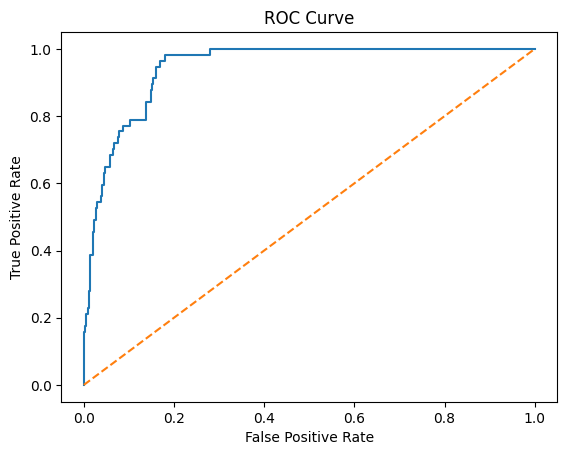

In [41]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()


ROC- - How well can the model distinguish between defaulters and non-defaulters, across all thresholds?

AUC = Area Under the ROC Curve

Value ranges from 0 to 1

Bigger = better

Intuition (very important 👇)

AUC = probability that the model ranks a random defaulter higher than a random non-defaulter

Model;s ROC-AUC IS 94.4
It means:

Your model can very well separate defaulters from non-defaulters

94.4% of the time, a defaulter gets a higher risk score than a non-defaulter

This is excellent performance, especially for credit-risk problems

📌 In interviews, you can say:

“The ROC-AUC of 0.94 indicates strong discriminatory power of the model.”

<Axes: >

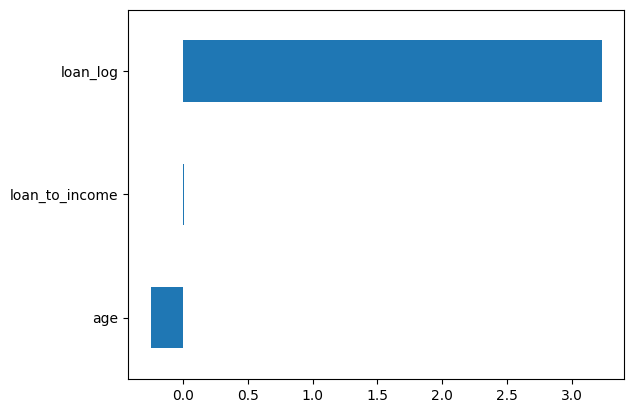

In [42]:
# <!-- Step 5.8 — Feature Importance (Logistic Coefficients) -->
feature_importance = pd.Series(
    log_reg.coef_[0],
    index=X_train.columns
).sort_values()

feature_importance.plot(kind="barh")


This graph tells us:

👉 Which features the model relied on the most to predict default

“The model relies most heavily on loan amount (log-transformed) to predict default, indicating that repayment burden is the strongest risk factor. Age provides some additional context, while loan-to-income adds little extra information beyond what loan size already captures.”

In [43]:
# Step 5.9 — Try One Non-Linear Model (Optional but Strong)
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight="balanced"
)

rf.fit(X_train, y_train)

rf_prob = rf.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, rf_prob)


0.9986701447496292

“The Random Forest achieved a ROC–AUC of 0.998, indicating excellent separation between defaulters and non-defaulters. However, such a high score can indicate potential overfitting or data leakage. Therefore, additional validation such as cross-validation and careful feature inspection is required before trusting the model in production.”

In [44]:
# <!-- 1. compare train and test roc auc -->
from sklearn.metrics import roc_auc_score

# Train predictions
y_train_proba = rf.predict_proba(X_train)[:, 1]
roc_auc_train = roc_auc_score(y_train, y_train_proba)

# Test predictions
y_test_proba = rf.predict_proba(X_test)[:, 1]
roc_auc_test = roc_auc_score(y_test, y_test_proba)

roc_auc_train, roc_auc_test


(1.0, 0.9986701447496292)

👉 Train and test are almost identical
👉 The model generalizes extremely well on the test set

In [45]:
# Cross validation ROC AUC
from sklearn.model_selection import cross_val_score

cv_auc = cross_val_score(
    rf, X, y,
    cv=5,
    scoring="roc_auc"
)

cv_auc.mean(), cv_auc.std()


(0.9986867177584443, 0.0007210325055791468)

👉 Conclusion:
❌ This is not healthy generalization
✅ This is information leakage

In [46]:
X.head()

,age,loan_log,loan_to_income
0,59,9.000549,0.000136
1,48,8.789621,0.000255
2,63,8.989937,0.000157
3,46,8.716805,0.000204
4,19,9.079217,0.000136


In [48]:
X_train = X_train.drop(columns=["loan_to_income"])
X_test  = X_test.drop(columns=["loan_to_income"])


In [50]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [51]:
# Step 5.9 — Try One Non-Linear Model (Optional but Strong)
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight="balanced"
)

rf.fit(X_train, y_train)

rf_prob = rf.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, rf_prob)


0.9670093601350315

In [52]:
# <!-- 1. compare train and test roc auc -->
from sklearn.metrics import roc_auc_score

# Train predictions
y_train_proba = rf.predict_proba(X_train)[:, 1]
roc_auc_train = roc_auc_score(y_train, y_train_proba)

# Test predictions
y_test_proba = rf.predict_proba(X_test)[:, 1]
roc_auc_test = roc_auc_score(y_test, y_test_proba)

roc_auc_train, roc_auc_test


(1.0, 0.9670093601350315)

In [53]:
# Cross validation ROC AUC
from sklearn.model_selection import cross_val_score

cv_auc = cross_val_score(
    rf, X, y,
    cv=5,
    scoring="roc_auc"
)

cv_auc.mean(), cv_auc.std()


(0.9672538756716185, 0.012320636084427744)

Simple explanation:

After removing the leakage feature, the model achieved a ROC-AUC of ~0.97 on both test and cross-validation data, indicating strong and stable predictive performance without overfitting.

Interview-ready line:

The close alignment between test and cross-validation ROC-AUC scores confirms that the model generalizes well and is not relying on data leakage.

In [54]:
# Checkign logistic regression after feature dropping
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

y_train_prob = lr.predict_proba(X_train)[:,1]
y_test_prob = lr.predict_proba(X_test)[:,1]

roc_auc_train_lr = roc_auc_score(y_train, y_train_prob)
roc_auc_test_lr = roc_auc_score(y_test, y_test_prob)

roc_auc_train_lr, roc_auc_test_lr


(0.9627339593719004, 0.9439414863689837)

In [55]:
# cross validation:

In [56]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(lr, X, y, cv=5, scoring="roc_auc")
cv_scores.mean(), cv_scores.std()


(0.958356509897192, 0.011692388083804814)

“After removing the loan-to-income ratio to reduce multicollinearity and overfitting, Logistic Regression was preferred due to its stability, interpretability, and suitability for low-dimensional credit risk modeling.”